#### Configurations

In [1]:
data_path = './data/ATACSeq'
train_epoch = 50
train_batch = 512
train_task = 'cmp'
finetune_epoch = 50
finetune_batch = 5000
finetune_task = 'cmp'
transfer_epoch = 10
transfer_batch = 512
transfer_task = 'sgi'
clean_previous_results = True

In [2]:
import scanpy as sc
adata_atac = sc.read_h5ad(f'{data_path}/atac_processed.h5ad')
adata_gex  = sc.read_h5ad(f'{data_path}/gex_processed.h5ad')
adata_atac.obs['batch_train'] = 'train'
adata_atac.obs['batch_test'] = 'test'

In [3]:
import anndata as ad
all_batches = [
    's1d1', 's1d2', 's1d3',
    's2d1', 's2d4', 's2d5',
    's3d3', 's3d6', 's3d7', 's3d10',
    's4d1', 's4d8', 's4d9']
    
def split_data(test_batch_i):
    test_batch = all_batches[test_batch_i]
    train_batches = all_batches[:test_batch_i] + all_batches[test_batch_i+1:]
    adata_atac_train = ad.concat([adata_atac[adata_atac.obs['batch'] == train_batch] for train_batch in train_batches])
    adata_atac_test  = adata_atac[adata_atac.obs['batch'] == test_batch]
    adata_gex_train  = ad.concat([adata_gex[ adata_gex.obs['batch']  == train_batch] for train_batch in train_batches])
    adata_gex_test   = adata_gex[adata_gex.obs['batch']   == test_batch]
    return test_batch, [adata_atac_train, adata_gex_train], [adata_atac_test, adata_gex_test]

In [5]:
import sys
sys.path.append('src')
from src import UnitedNet
import os, shutil

models = {}
for test_batch_i, test_batch in enumerate(all_batches):
    log_path = f'saved_log_{test_batch}'
    model_path = f'saved_models_{test_batch}'
    tensorboard_path = f'saved_tensorboards_{test_batch}'
    if clean_previous_results:
        if os.path.exists(log_path):
            os.remove(log_path)
        if os.path.exists(model_path):
            shutil.rmtree(model_path)
        if os.path.exists(tensorboard_path):
            shutil.rmtree(tensorboard_path)

    test_batch_splitted, adatas_train, adatas_test = split_data(test_batch_i)
    assert test_batch == test_batch_splitted

    models[test_batch] = UnitedNet(
        log_path=log_path,
        model_path=model_path,
        tensorboard_path=tensorboard_path,
    )
    model = models[test_batch]
    model.register_anndatas(
        adatas_train, 
        label_index=0, label_key='cell_type', batch_index=0, batch_key='batch_train',
    )
    model.set_device('cuda:0')
    model.train(
        train_task, n_epoch=train_epoch, batch_size=train_batch, 
        save_best_model=True, checkpoint=1,
    )
    model.finetune(
        finetune_task, n_epoch=finetune_epoch, batch_size=finetune_batch, 
        save_best_model=True, checkpoint=1,
    )
    model.transfer(
        transfer_task, n_epoch=transfer_epoch, batch_size=transfer_batch,
        adatas_transfer=adatas_test, 
        label_index_transfer=0, label_key_transfer='cell_type', 
        batch_index_transfer=0, batch_key_transfer='batch_test',
        save_best_model=True, checkpoint=1, 
    )
    print('Training Data', '*'*20)
    model.evaluate()
    print('Testing Data', '*'*20)
    model.evaluate(
        adatas_test, 
        label_index_evaluate=0, label_key_evaluate='cell_type',
        batch_index_evaluate=0, batch_key_evaluate='batch_test',
    )


TRAIN Task: cross_model_prediction

    (Epoch 1 / 2)
    ========== Schedule 0: classification ==========
    Losses
        contrastive: 3.5069141387939453
        cross_entropy: 1.217835783958435
        reconstruction: 1.1310368776321411
    Losses
        contrastive: 1.9219168424606323
        cross_entropy: 0.658898651599884
        reconstruction: 1.1059778928756714
            Saving model to saved_models_s1d1/cmp_train_0_classification/best.pt
            Saving model to saved_models_s1d1/cmp_train_0_classification/epoch_1.pt
    ========== Schedule 1: translation ==========
    Losses
        contrastive: 1.6841609477996826
        discriminator: 0.7576619982719421
        generator: 0.35784950852394104
        reconstruction: 0.5460464954376221
        translation: 0.55494225025177
    Losses
        contrastive: 0.9018478989601135
        discriminator: 0.7416033148765564
        generator: 0.33650192618370056
        reconstruction: 0.3729468286037445
        translation:

INFER  


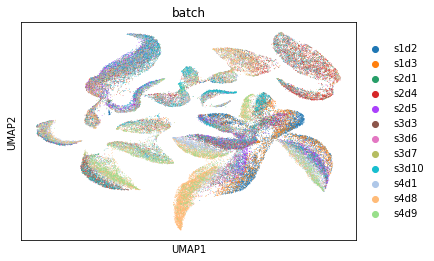

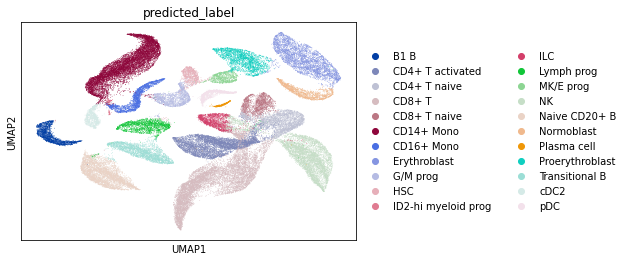

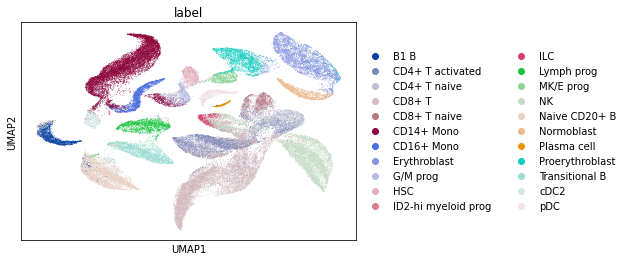

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models_s1d2/sgi_transfer_3_classification/best.pt'

In [9]:
for test_batch_i, test_batch in enumerate(all_batches):
    test_batch_splitted, adatas_train, adatas_test = split_data(test_batch_i)
    assert test_batch == test_batch_splitted

    model = UnitedNet(
        log_path=None,
        model_path=None,
        tensorboard_path=None,
    )
    model.load_model(f'saved_models_{test_batch}/sgi_transfer_3_classification/best.pt')
    adata_train_inferred = model.infer(
        adatas_train, 
        modalities_provided=[0, 1],
        batch_index_infer=0, batch_key_infer='batch_train', 
        modality_sizes=[13634, 4000]
    )
    adata_train_inferred.obs['batch'] = list(adatas_train[0].obs['batch'])
    adata_train_inferred.obs['label'] = list(adatas_train[0].obs['cell_type'])
    sc.pl.umap(adata_train_inferred, color=['batch'])
    sc.pl.umap(adata_train_inferred, color=['predicted_label'])
    sc.pl.umap(adata_train_inferred, color=['label'])

INFER  


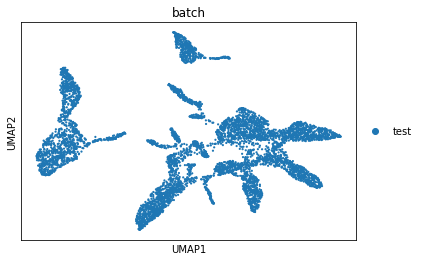

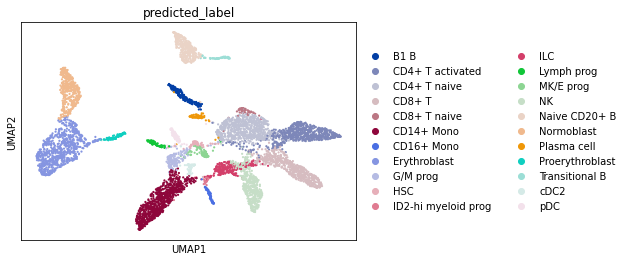

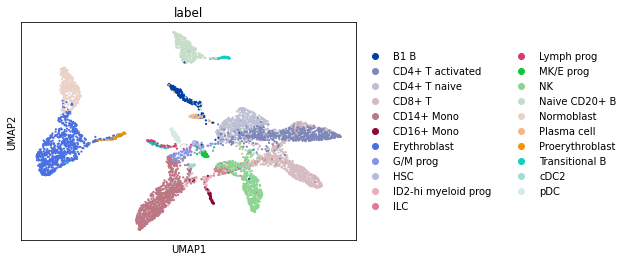

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models_s1d2/sgi_transfer_3_classification/best.pt'

In [8]:
for test_batch_i, test_batch in enumerate(all_batches):
    test_batch_splitted, adatas_train, adatas_test = split_data(test_batch_i)
    assert test_batch == test_batch_splitted

    model = UnitedNet(
        log_path=None,
        model_path=None,
        tensorboard_path=None,
    )
    model.load_model(f'saved_models_{test_batch}/sgi_transfer_3_classification/best.pt')
    adata_test_inferred = model.infer(
        adatas_test, 
        modalities_provided=[0, 1],
        batch_index_infer=0, batch_key_infer='batch_test', 
        modality_sizes=[13634, 4000]
    )
    adata_test_inferred.obs['batch'] = list(adatas_test[0].obs['batch'])
    adata_test_inferred.obs['label'] = list(adatas_test[0].obs['cell_type'])
    sc.pl.umap(adata_test_inferred, color=['batch'])
    sc.pl.umap(adata_test_inferred, color=['predicted_label'])
    sc.pl.umap(adata_test_inferred, color=['label'])

In [11]:
for test_batch_i, test_batch in enumerate(all_batches):
    test_batch_splitted, adatas_train, adatas_test = split_data(test_batch_i)
    assert test_batch == test_batch_splitted

    adatas_train[0].obs['batch_all'] = 'train'
    adatas_test[0].obs['batch_all']  = 'test'
    adatas_all = [ad.concat(adatas_train[0], adatas_test[0]), ad.concat(adatas_train[1], adatas_test[1])]
    
    model = UnitedNet(
        log_path=None,
        model_path=None,
        tensorboard_path=None,
    )
    model.load_model(f'saved_models_{test_batch}/sgi_transfer_3_classification/best.pt')
    adata_all_inferred = model.infer(
        adatas_all, 
        modalities_provided=[0, 1],
        batch_index_infer=0, batch_key_infer='batch_all', 
        modality_sizes=[13634, 4000]
    )
    adata_all_inferred.obs['batch'] = list(adatas_all[0].obs['batch'])
    adata_all_inferred.obs['label'] = list(adatas_all[0].obs['cell_type'])
    sc.pl.umap(adata_all_inferred, color=['batch'])
    sc.pl.umap(adata_all_inferred, color=['predicted_label'])
    sc.pl.umap(adata_all_inferred, color=['label'])

C:\ProgramData\Anaconda3\envs\untest\lib\site-packages\ipykernel_launcher.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  
C:\ProgramData\Anaconda3\envs\untest\lib\site-packages\ipykernel_launcher.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\envs\untest\lib\site-packages\debugpy\_vendored\pydevd\_pydevd_bundle\pydevd_resolver.py:193: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  attr = getattr(var, name)
